In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as ani
import matplotlib.cm as cm  

In [157]:
#constants of nature

mu0 = 4 * np.pi * 1e-7
e0 = 8.85e-12
c = np.sqrt(1 / (mu0 * e0))
k = 1 / (4 * np.pi * e0)
print("the speed of light is:", c)
c = 0.5

dt = 0.0007

the speed of light is: 299863380.46612763


In [158]:
t0 = 0
t1 = 40
timesteps = np.arange(t0, t1, dt)
print(timesteps.shape)

(57143,)


In [159]:
def external_force_func(E0,omega,timesteps):
    return (E0 * np.sin(omega * timesteps))

E0 = 0.03 #0.02
omega = np.sqrt(2) 

external_force_arr = external_force_func(E0,omega,timesteps)
    

In [160]:
class Particle:
    
    def __init__(self, mass=1, charge=1, pos=np.array([0.0,0.0,0.0]), vel=np.array([0.0,0.0,0.0]), acc=np.array([0.0,0.0,0.0])):
        self.mass = mass
        self.charge = charge
        self.pos = pos
        self.vel = vel
        self.acc = acc

class Dipole:
    
    def __init__(self, timesteps, distance=1, charge=1, k=1):
        self.distance = distance
        self.charge = charge
        self.mass = 1
        self.particle1 = Particle(mass=self.mass, charge=self.charge, pos=np.array([-distance/2, 0,0]))
        self.particle2 = Particle(mass=self.mass, charge=-self.charge, pos=np.array([distance/2, 0,0]))
        self.dipole_moment = self.charge * np.array([self.distance, 0, 0])
        self.force = 0
        self.timesteps = timesteps
        self.pos1 = np.zeros((self.timesteps.size, 3))
        self.pos2 = np.zeros((self.timesteps.size, 3))
        self.k = k
        
    def update(self, external_force):
        r = self.particle2.pos - self.particle1.pos
        
        spring_force = self.k * (np.linalg.norm(r) - self.distance) * (r / np.linalg.norm(r))
        force = spring_force + external_force * self.charge
        
        self.particle1.acc = force / self.particle1.mass
        self.particle2.acc = -force / self.particle2.mass
        self.particle1.vel = self.particle1.vel + self.particle1.acc * dt
        self.particle2.vel = self.particle2.vel + self.particle2.acc * dt
        
        self.particle1.pos += self.particle1.vel * dt
        self.particle2.pos += self.particle2.vel * dt
        
    def calc_trajectory(self):
        
        for i, time in enumerate(self.timesteps):
            self.pos1[i] = self.particle1.pos
            self.pos2[i] = self.particle2.pos
            
            external_force = np.array([external_force_arr[i], 0, 0])
            
            self.update(external_force)
            
        return self.pos1, self.pos2
        

<IPython.core.display.Javascript object>


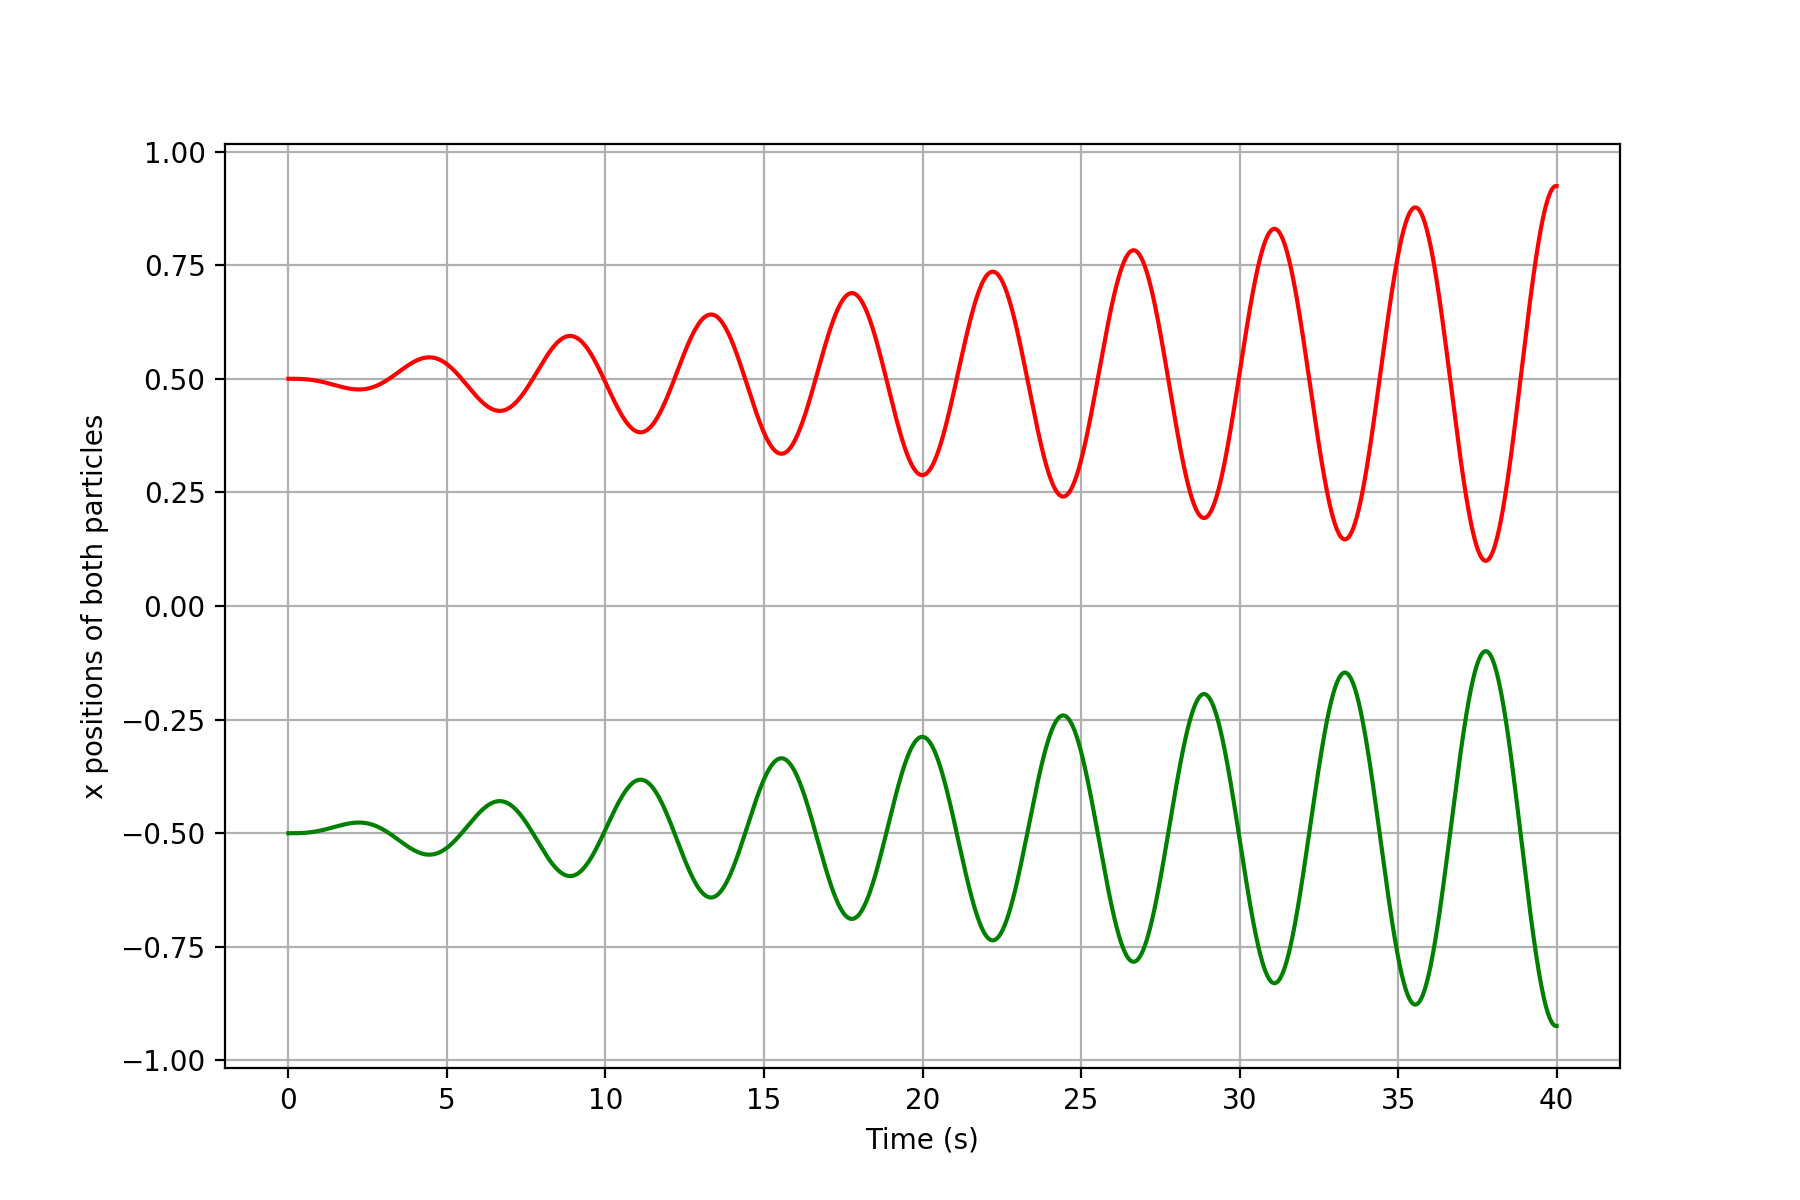

Text(0, 0.5, 'x positions of both particles')

In [161]:
dipole = Dipole(timesteps)

dipole.calc_trajectory()


fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(timesteps, dipole.pos1[:, 0], 'g')
ax1.plot(timesteps, dipole.pos2[:, 0], 'r')
ax1.grid()


ax1.set_xlabel("Time (s)")
ax1.set_ylabel("x positions of both particles")

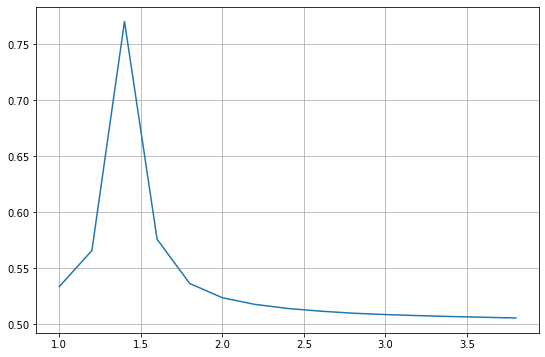

In [7]:
omega_arr = np.arange(1,4,0.2)
E0 = 0.02
plot_store = np.zeros(np.shape(omega_arr))
for i in range(np.size(omega_arr)):
    external_force_arr = external_force_func(E0,omega_arr[i],timesteps)
    dipole_arr = Dipole(timesteps)
    posA,posB = dipole_arr.calc_trajectory()    
    plot_store[i] = np.amax(posB)
    #print(np.amax(posB))
    

    
fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(omega_arr,plot_store)
ax1.grid()

In [29]:
def binary_search(array, value):
    low = 0
    high = array.size - 1
    midpoint = int((high - low) / 2)
    n = 0
    
    if value > array[high]:
        return -1
    
    while(low <= high and n < array.size):
        n+=1
        midpoint = int((low + high) / 2)
        if array[midpoint] == value:
            return midpoint
        elif array[midpoint] > value:
            high = midpoint - 1
        elif array[midpoint] < value:
            low = midpoint + 1
    return midpoint


In [30]:
class point_in_space():
    
    def __init__(self, x, y, z, timesteps):
        self.xyz = np.array([x, y, z])
        self.electric_field = np.zeros((timesteps.size, 3))
        self.electric_field_1 = np.zeros((timesteps.size, 3))
        self.electric_field_2 = np.zeros((timesteps.size, 3))
        self.first_index = 0
        self.first_index1 = 0
        self.first_index2 = 0
        self.iteration_flag = False
        
    def reset_electric_field(self):
        self.electric_field_1 = np.zeros((timesteps.size, 3))
        self.electric_field_2 = np.zeros((timesteps.size, 3))


In [31]:
indices = np.zeros(timesteps.shape)
def populate_electric_field_array(pos1, pos2, point_in_space, time, i):
    r1 = point_in_space.xyz - pos1
    r2 = point_in_space.xyz - pos2
    
    time1 = time + np.linalg.norm(r1) / c
    time2 = time + np.linalg.norm(r2) / c
    
    index1 = binary_search(timesteps, time1)
    index2 = binary_search(timesteps, time2)
    
    indices[i] = index1
    
    r_mag1 = np.linalg.norm(r1)
    r_mag2 = np.linalg.norm(r2)
    
    Ex1 = dipole.charge * (r1[0]*r_mag1**-3)
    Ey1 = dipole.charge * (r1[1]*r_mag1**-3)
    Ez1 = dipole.charge * (r1[2]*r_mag1**-3)
    
    Ex2 = -dipole.charge * (r2[0]*r_mag2**-3)
    Ey2 = -dipole.charge * (r2[1]*r_mag2**-3)
    Ez2 = -dipole.charge * (r2[2]*r_mag2**-3)
    
    if index1 != -1:
        point_in_space.electric_field_1[index1] = np.array([Ex1, Ey1, Ez1])
    if index2 != -1:
        point_in_space.electric_field_2[index2] = np.array([Ex2, Ey2, Ez2])
    
    if index1 == -1 and index2 == -1:
        point_in_space.iteration_flag = True
        
    if(i == 0):
        point_in_space.first_index1 = index1
        point_in_space.first_index2 = index2
        point_in_space.electric_field_1[:index1] = np.array([Ex1, Ey1, Ez1])
        point_in_space.electric_field_2[:index2] = np.array([Ex2, Ey2, Ez2])

p2 = point_in_space(-.75, -.5, 0, timesteps)
populate_electric_field_array(dipole.pos1[0], dipole.pos2[0], p2, 0, 0)
print(p2.first_index1)

400


In [32]:
def relax(arr, relax_mask):
    keep_same = arr[relax_mask]
    first = arr[0]
    last = arr[-1]    
    
    arr = (np.roll(arr,-1, axis=0) + np.roll(arr,1,axis=0))/2
    
    arr[relax_mask] = keep_same
    arr[0] = first
    arr[-1] = last
    return arr
    
    

In [163]:
iterations = 1000
def calculate_electric_field(point_in_space, dipole):
    pos1 = dipole.pos1
    pos2 = dipole.pos2
    for i, t in enumerate(timesteps):
        populate_electric_field_array(pos1[i], pos2[i], point_in_space, t, i)
        if point_in_space.iteration_flag:
#             print("calculation done in", i, "iterations")
            break
    point_in_space.first_index = np.max(point_in_space.first_index1 + point_in_space.first_index2)
    
    relax_mask_1 = np.where(np.abs(point_in_space.electric_field_1) != 0)
    relax_mask_2 = np.where(np.abs(point_in_space.electric_field_2) != 0)

    for i in range(iterations):
        point_in_space.electric_field_1 = relax(point_in_space.electric_field_1, relax_mask_1)
        point_in_space.electric_field_2 = relax(point_in_space.electric_field_2, relax_mask_2)
    
    point_in_space.electric_field = point_in_space.electric_field_1 + point_in_space.electric_field_2
    

In [41]:
p1 = point_in_space(-0.75, -0.5, 0, timesteps)
p1.reset_electric_field()
calculate_electric_field(p1, dipole)

calculation done in 56770 iterations


<IPython.core.display.Javascript object>


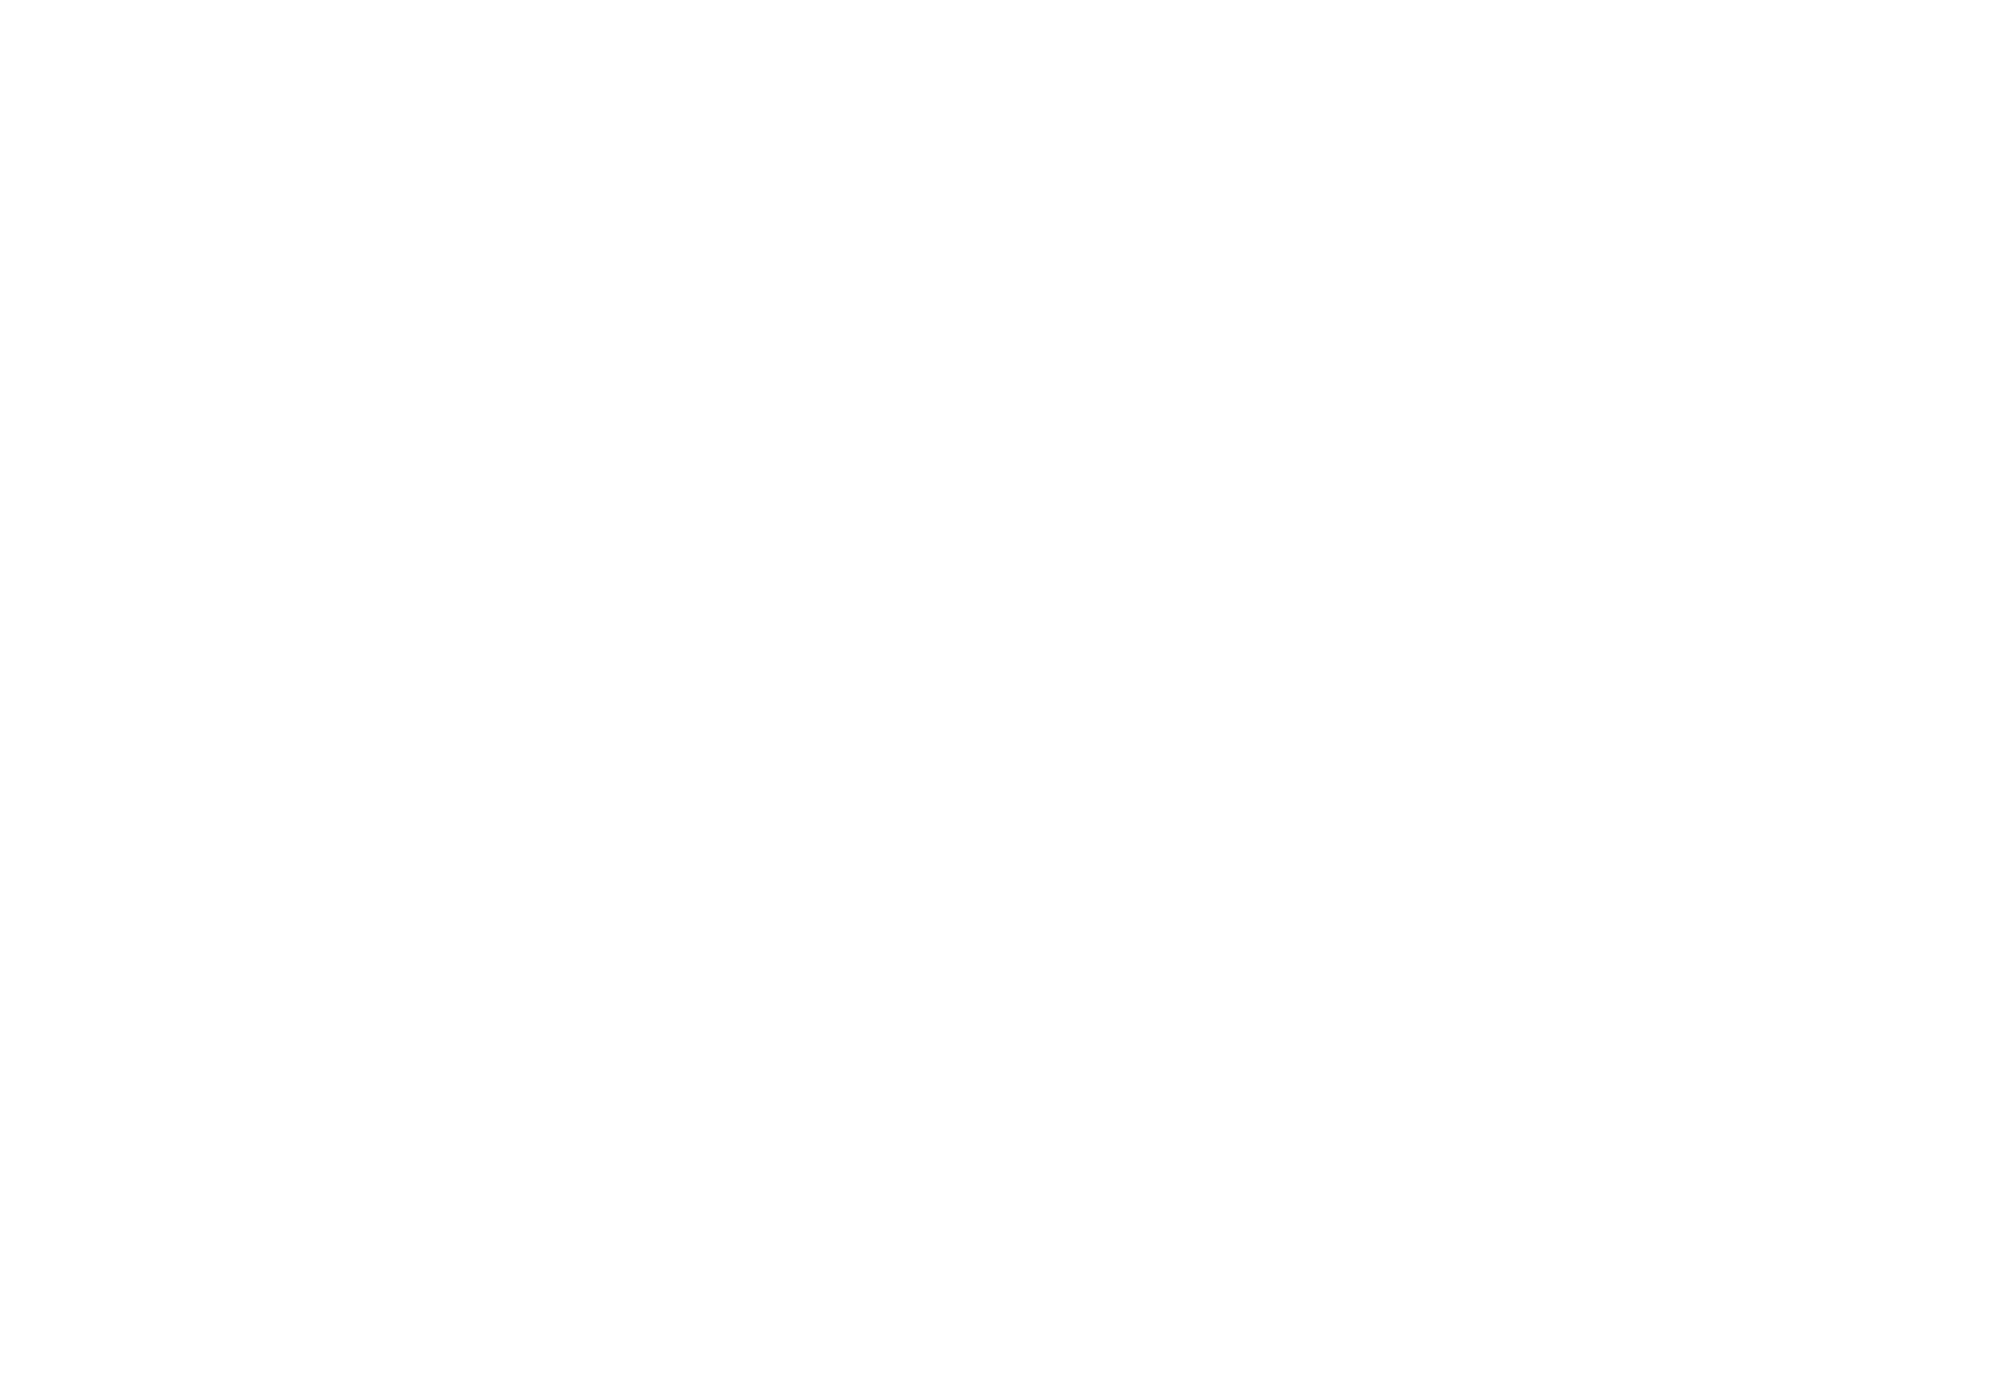

In [35]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,7))
ax1.plot(timesteps[:], p1.electric_field_1[:, 1], 'b-')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("E_x due to particle 1")
#ax1.legend()


ax2.plot(timesteps[:], p1.electric_field_2[:, 1], 'r-')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("E_x due to particle 2")


ax3.plot(timesteps, p1.electric_field[:, 0], 'g-')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("mag(E)_x due to both particles")

ax1.grid()
ax2.grid()
ax3.grid()





In [42]:
p2 = point_in_space(0.5, -0.2, 0, timesteps)
p2.reset_electric_field()
calculate_electric_field(p2, dipole)

calculation done in 56820 iterations


In [43]:
p3 = point_in_space(-0.75, -0.2, 0, timesteps)
p3.reset_electric_field()
calculate_electric_field(p3, dipole)

p4 = point_in_space(-0.75, 0.6, 0, timesteps)
p4.reset_electric_field()
calculate_electric_field(p4, dipole)

calculation done in 56956 iterations
calculation done in 56703 iterations


In [168]:
def calculate_vector_evolution_array(x, y, dipole):
    vector_evolution = np.empty(x.size, dtype=point_in_space)
    num_points = x.size
    for i in range(num_points):
        point = point_in_space(x[i], y[i], 0, timesteps)
        calculate_electric_field(point, dipole)
        vector_evolution[i] = point
        
        print("calculated electric field evolution ", (i + 1), "out of ", num_points)
    
    return vector_evolution

In [169]:
Nsteps = 8
grid_min = -1
grid_max = 1

x_grid, y_grid = np.meshgrid(np.linspace(grid_min, grid_max, Nsteps),
                      np.linspace(grid_min, grid_max, Nsteps))

x_test = np.ravel(x_grid)
y_test = np.ravel(y_grid)

p_array_test = calculate_vector_evolution_array(x_test, y_test, dipole)

calculated electric field evolution  1 out of  64
calculated electric field evolution  2 out of  64
calculated electric field evolution  3 out of  64
calculated electric field evolution  4 out of  64
calculated electric field evolution  5 out of  64
calculated electric field evolution  6 out of  64
calculated electric field evolution  7 out of  64
calculated electric field evolution  8 out of  64
calculated electric field evolution  9 out of  64
calculated electric field evolution  10 out of  64
calculated electric field evolution  11 out of  64
calculated electric field evolution  12 out of  64
calculated electric field evolution  13 out of  64
calculated electric field evolution  14 out of  64
calculated electric field evolution  15 out of  64
calculated electric field evolution  16 out of  64
calculated electric field evolution  17 out of  64
calculated electric field evolution  18 out of  64
calculated electric field evolution  19 out of  64
calculated electric field evolution  20 

In [144]:
def get_2D_electric_field(p_array, unit_vectors=True):
    x = np.zeros(p_array.size)
    y = np.zeros(p_array.size)
    Ex = np.zeros((p_array.size, timesteps.size))
    Ey = np.zeros((p_array.size, timesteps.size))
    for i, point in enumerate(p_array):
        x[i] = point.xyz[0]
        y[i] = point.xyz[1]
        Ex_current = point.electric_field[:, 0]
        Ey_current = point.electric_field[:, 1]
        
        if unit_vectors:
            mag_vec = np.sqrt(Ex_current**2 + Ey_current**2)
            Ex[i] = Ex_current / mag_vec
            Ey[i] = Ey_current / mag_vec   
        else:
            Ex[i] = Ex_current
            Ey[i] = Ey_current
        
    return x, y, Ex, Ey
    

<IPython.core.display.Javascript object>


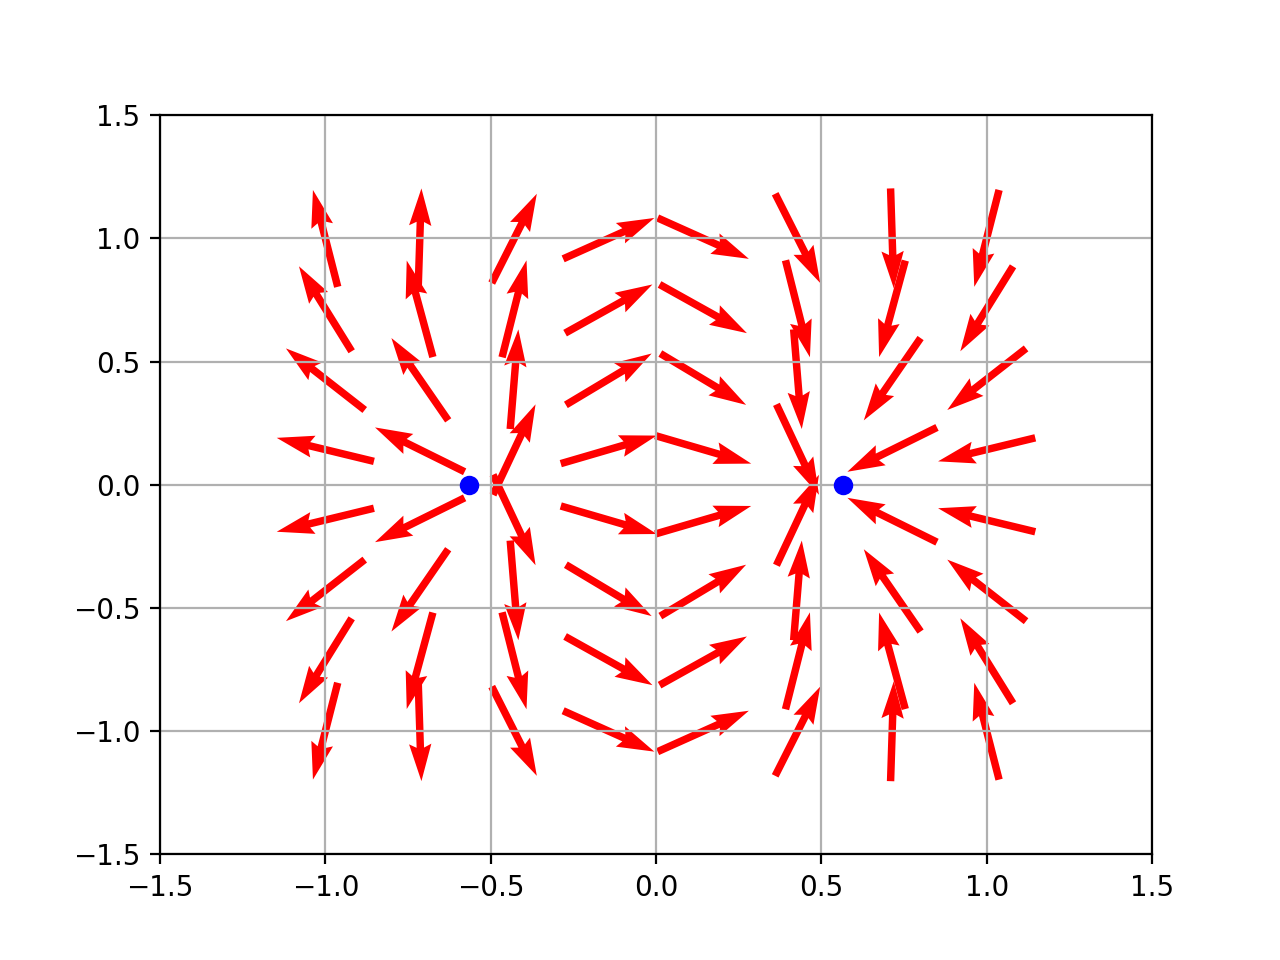

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [171]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
index = 0
speed_factor = 10
scale_factor = 1
frame_num = int(timesteps.size / speed_factor)

p_array = p_array_test
x, y, Ex, Ey = get_2D_electric_field(p_array, unit_vectors=True)
    
plt.grid()

E_changing_plot = ax.quiver(x, y, 
                   Ex[:, 0], Ey[:, 0], 
                   units='inches',pivot='mid',color='r', scale=2)

pos1 = dipole.pos1
pos2 = dipole.pos2
dipole_plot, = ax.plot([pos1[0][0], pos2[0][0]], [pos1[0][1], pos2[0][1]], 'bo')


x_comp_0 = Ex[:, 0]
y_comp_0 = Ey[:, 0]
vec = np.array([Ex, Ey, np.zeros(Ex.shape)])


unit_vecs = np.zeros((x_comp_0.size, 3))

    
def plot_point_in_space(i):
    x_component = Ex[:, i * speed_factor] * scale_factor
    y_component = Ey[:, i * speed_factor] * scale_factor
    
    E_changing_plot.set_UVC(x_component, y_component)
    
    dipole_x = [pos1[i * speed_factor, 0], pos2[i * speed_factor, 0]]
#     dipole_y = [pos1[i * speed_factor, 1], pos2[i * speed_factor, 1]]
    
    dipole_plot.set_xdata(dipole_x)
    
    return dipole_plot, E_changing_plot

anim = ani.FuncAnimation(fig, plot_point_in_space,
                               frames=frame_num, interval=1, blit=False)
plt.show()

In [18]:
def calc_electric_field(dipole, point):
    dif1 = point - dipole.particle1.pos
    dif2 = point - dipole.particle2.pos
    
    r_mag1 = np.linalg.norm(dif1)
    r_mag2 = np.linalg.norm(dif2)
    
    Ex = dipole.charge * (dif1[0]*r_mag1**-3 - dif2[0]*r_mag2**-3)
    Ey = dipole.charge * (dif1[1]*r_mag1**-3 - dif2[1]*r_mag2**-3)
    Ez = dipole.charge * (dif1[2]*r_mag1**-3 - dif2[2]*r_mag2**-3)
    
    return np.array([Ex, Ey, Ez])

print(calc_electric_field(dipole, [-0.75, -0.5, 0]))

[ 1.48670293 -3.27575157  0.        ]


<IPython.core.display.Javascript object>


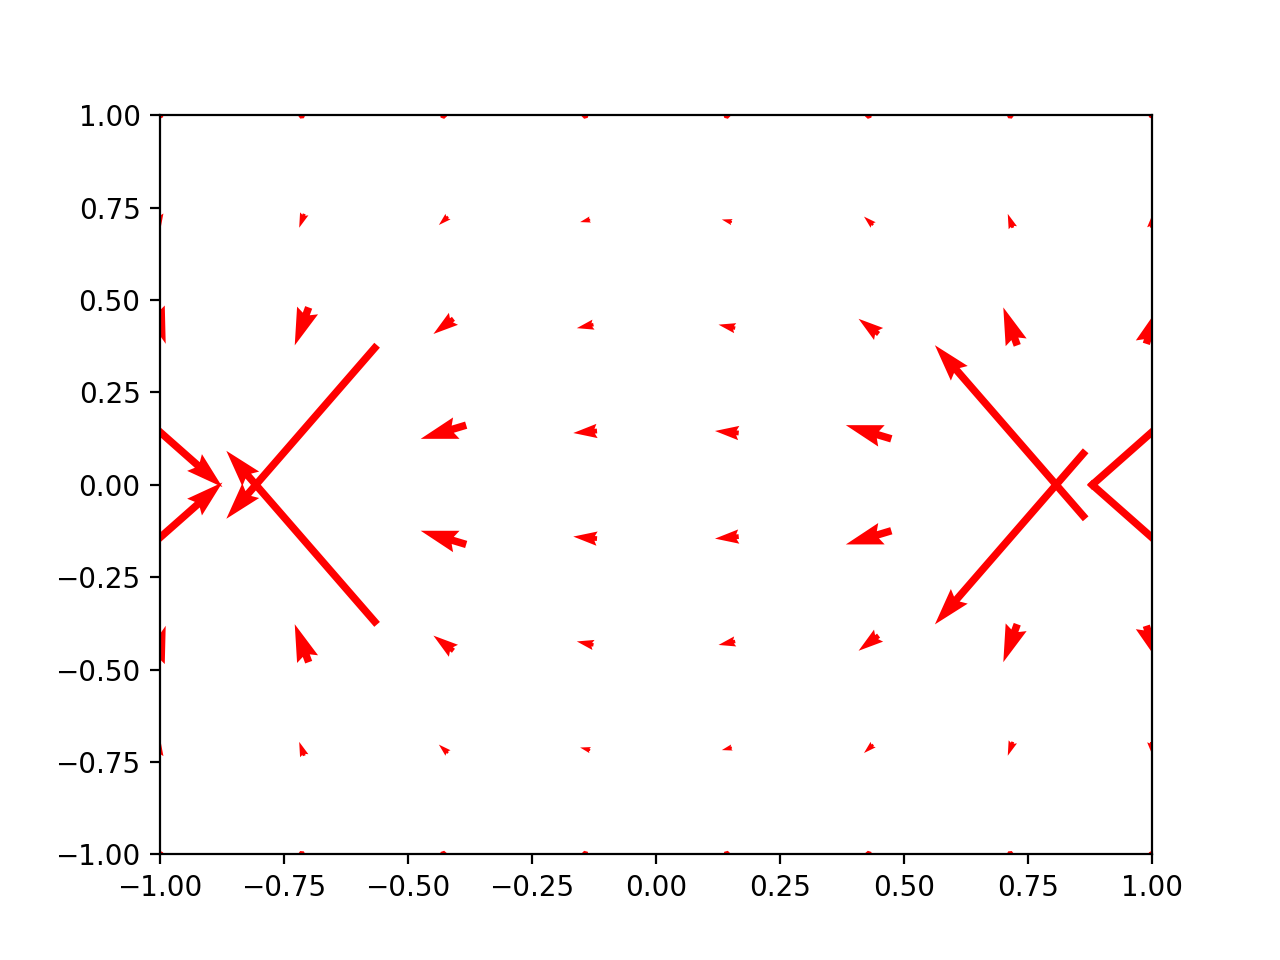

64


In [81]:
pos1, pos2 = dipole.calc_trajectory()
fig = plt.figure()
ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))

Nsteps = 8
grid_min = -1
grid_max = 1

x, y = np.meshgrid(np.linspace(grid_min, grid_max, Nsteps),
                      np.linspace(grid_min, grid_max, Nsteps))
E = calc_electric_field(dipole, [x, y, 0])

magEfield = np.sqrt(E[0]**2 + E[1]**2 + E[2]**2)
maxMagEfield = np.max(magEfield)

mask_efield = np.where(magEfield < maxMagEfield * 1.1)
print(x.size)

Qplot = ax.quiver(x[mask_efield], y[mask_efield], 
                   E[0][mask_efield], E[1][mask_efield], 
                   units='inches',pivot='mid',color='r', scale=25)

In [22]:
E0 = 0.02
omega = np.sqrt(2)

omega_2 = 0

def piecewise_force(timesteps,E0):
    force = np.zeros(np.shape(timesteps))
    for i in range(np.size(timesteps)):
        if i < np.size(timesteps)/2:
            force[i] = E0
        else:
            force[i] = 0
    return force
 


dipole_2 = Dipole(timesteps = timesteps, distance =1,k = 0)
external_force_arr = piecewise_force(timesteps,E0)
posa,posb = dipole_2.calc_trajectory()

new_point = point_in_space(0.5, 5, 0, timesteps)
new_point.reset_electric_field()
calculate_electric_field(new_point,dipole_2)

calculation done in 49820 iterations


<IPython.core.display.Javascript object>


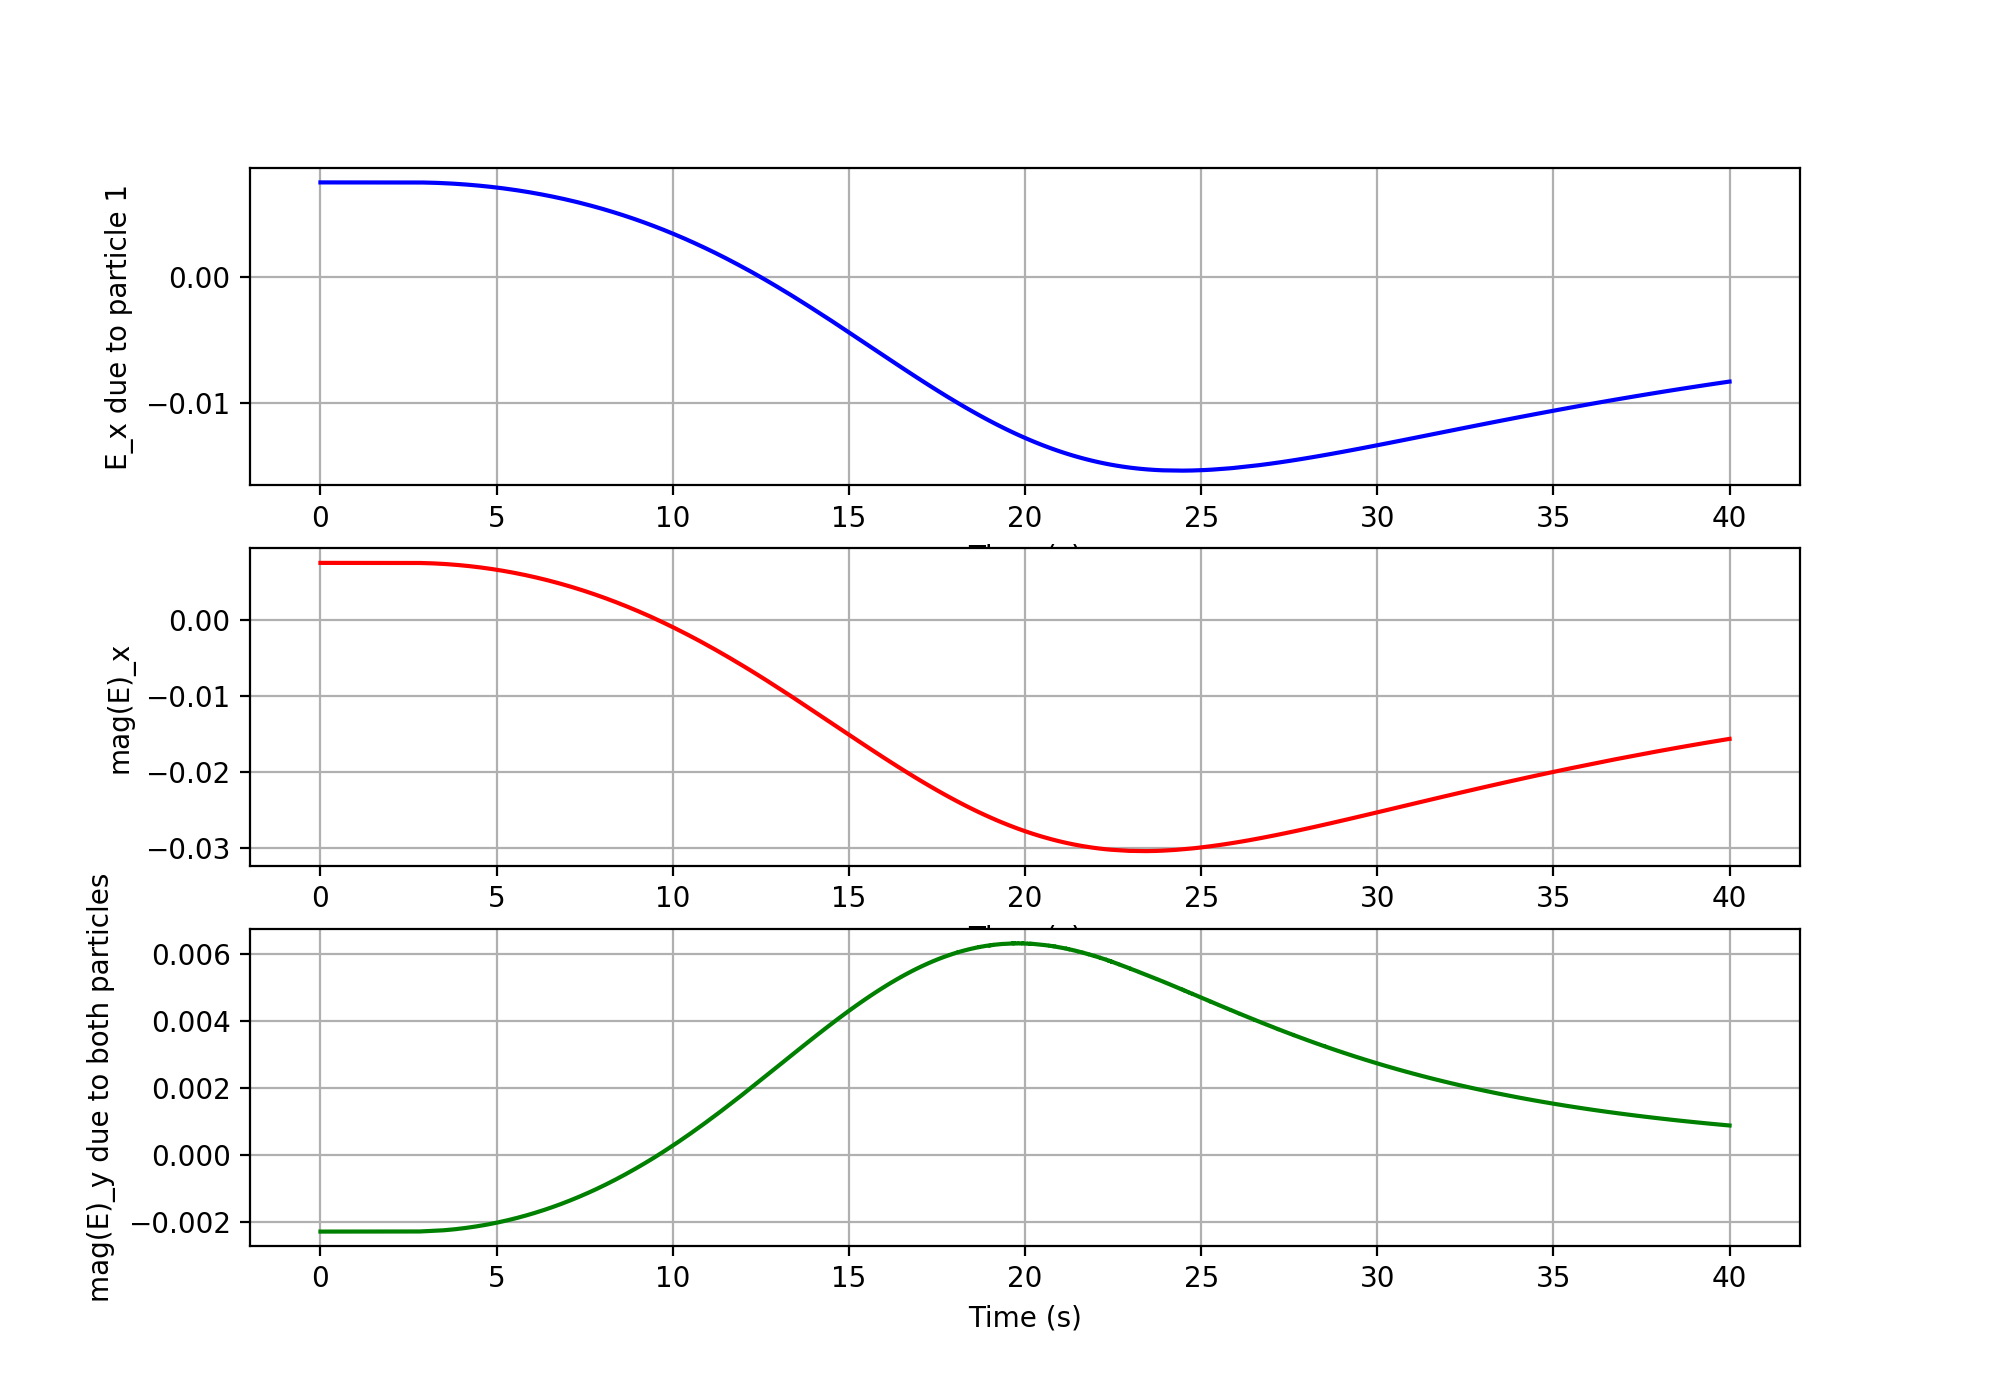

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,7))
ax1.plot(timesteps, new_point.electric_field_1[:, 0], 'b-')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("E_x due to particle 1")
#ax1.legend()


ax2.plot(timesteps, new_point.electric_field[:, 0], 'r-')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("mag(E)_x")


ax3.plot(timesteps, new_point.electric_field[:, 1], 'g-')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("mag(E)_y due to both particles")

ax1.grid()
ax2.grid()
ax3.grid()

<IPython.core.display.Javascript object>


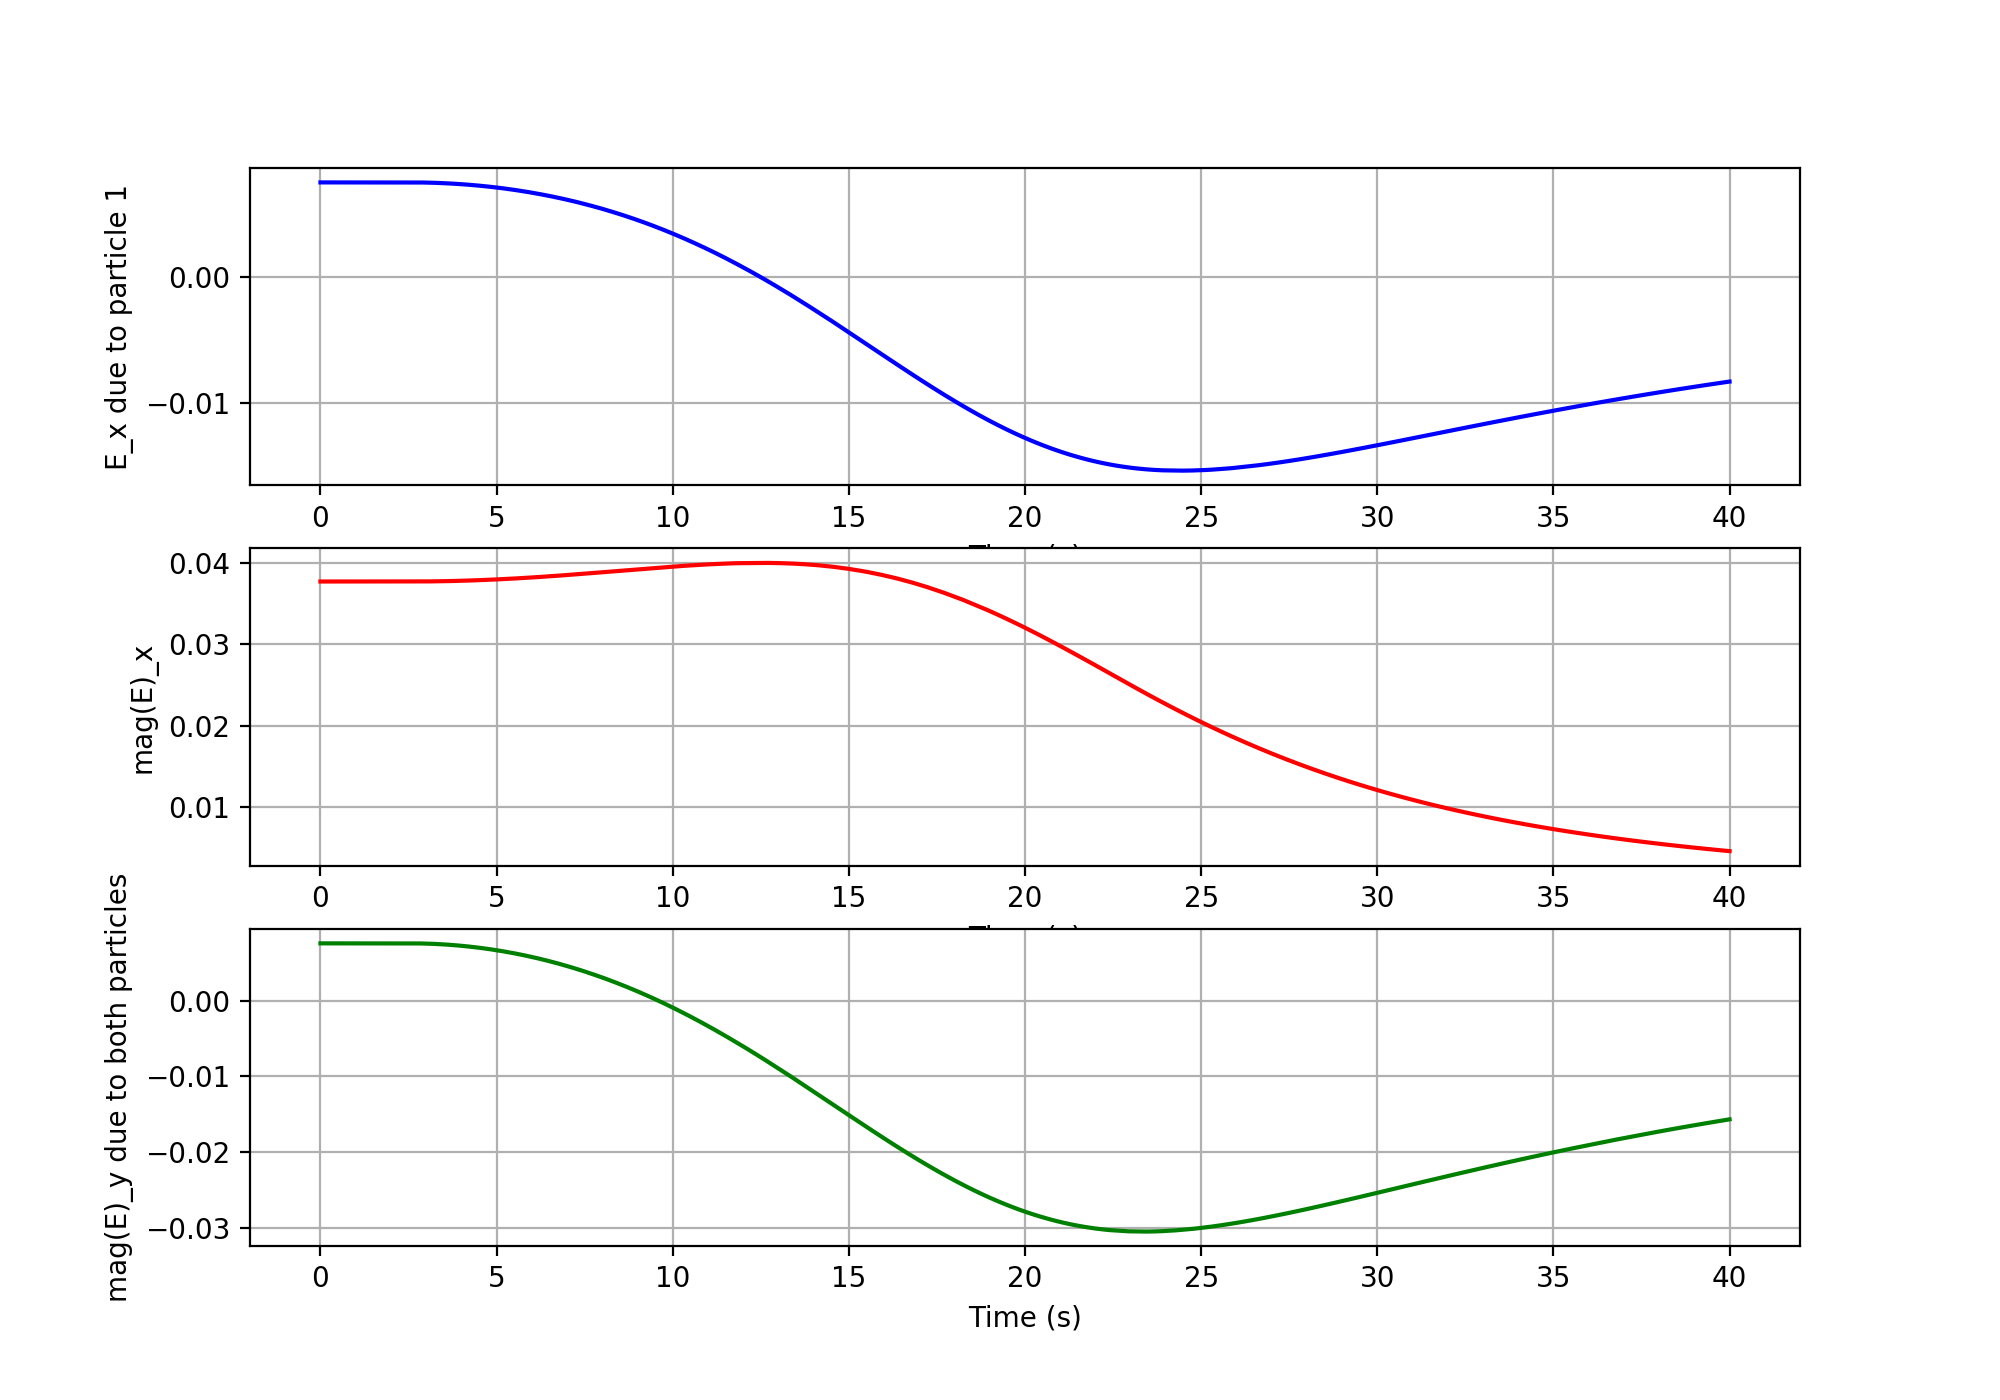

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,7))
ax1.plot(timesteps, new_point.electric_field_1[:, 0], 'b-')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("E_x due to particle 1")
#ax1.legend()


ax2.plot(timesteps, new_point.electric_field_1[:, 1], 'r-')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("mag(E)_x")


ax3.plot(timesteps, new_point.electric_field[:, 0], 'g-')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("mag(E)_y due to both particles")

ax1.grid()
ax2.grid()
ax3.grid()

<IPython.core.display.Javascript object>


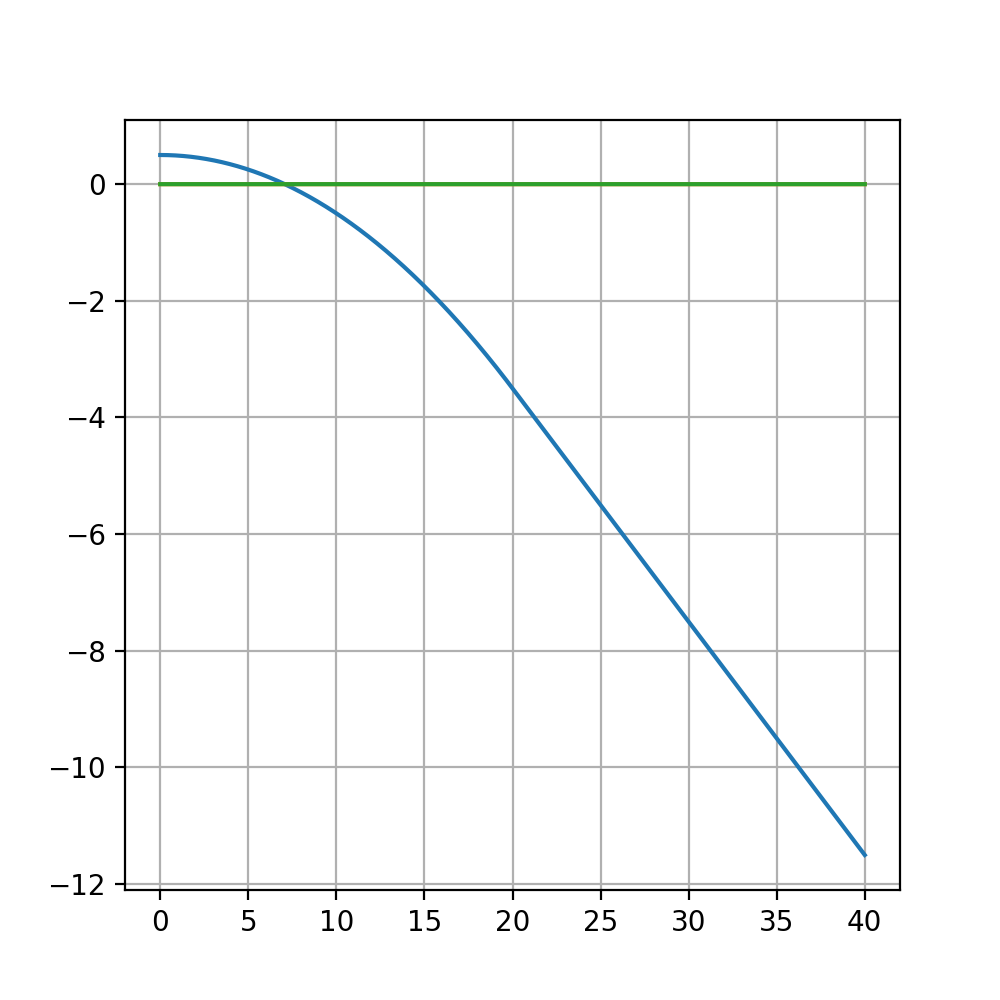

In [25]:
fig, (ax1) = plt.subplots(1, figsize=(5,5))
ax1.plot(timesteps,dipole_2.pos2)
ax1.grid()